<hr style="border: none; border-top: 2px solid black;" />

---

# Notebook to read and plot LIGO data
---
<hr style="border: none; border-top: 2px solid black;" />


##### First we import the needed packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, tables

from astropy.coordinates import EarthLocation, SkyCoord
from astropy.coordinates import AltAz
from astropy import units as u
from astropy.io import fits

import healpy as hp
import scipy.ndimage

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")



import ligo.skymap.plot
from ligo.skymap.plot import blackmarble, reproject_interp_rgb, bluemarble
import ligo.skymap.io.fits
from astropy.io import fits

import plotting

# --- Hard-Coded parameters --- #
root = os.getcwd() # Root directory where the script is running
dir_plots = root + "/plots/" # Directory to store plots

In [2]:
from ligo.skymap.io.fits import read_sky_map

from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

def healpix2map(
    healpix_data,
    ra_bins, 
    dec_bins,
):
    
    ra_grid, dec_grid = np.meshgrid(ra_bins, dec_bins)

    # Convert the latitude and longitude to theta and phi
    theta, phi = np.radians(90 - dec_grid), np.radians(ra_grid)
    
    nside = hp.npix2nside(len(healpix_data)) # nside of the grid

    # Convert theta, phi to HEALPix indices and create a 2D map using the HEALPix data
    hp_indices = hp.ang2pix(nside, theta, phi)

    return (healpix_data[hp_indices])

def get_hp_map_thresholds(healpix_data, threshold_percent = [0.9, 0.68],):
    
    # We sort the tresholds itself in descending order
    threshold_percent = np.sort(threshold_percent)[::-1]
    
    # Sort in descending order and normalize
    sorted_data = np.sort(healpix_data)[::-1] / np.sum(healpix_data)
    cumulative_sum = np.cumsum(sorted_data)

    # Find the values corresponding to the thresholds
    indexes_map = [np.searchsorted(cumulative_sum, t) for t in threshold_percent]
    # Then we find the thresholds
    threshold_maps = [sorted_data[min(index, len(sorted_data) - 1)] for index in indexes_map]
    
    return threshold_maps

def get_2d_map_hotspot(map_data_2d, ra_bins, dec_bins):
    
    # Computing coordinate of maximum probability
    max_prob_index = np.unravel_index(np.argmax(map_data_2d), map_data_2d.shape)
    
    max_prob_ra, max_prob_dec = ra_bins[max_prob_index[1]], dec_bins[max_prob_index[0]]
    max_prob_coords = SkyCoord(ra=max_prob_ra, dec=max_prob_dec, unit=u.deg, frame="icrs")
    return max_prob_coords

## Parameters

In [3]:
filename = "./data/data_LIGO.fits"

source_name = "S241125n"

threshold_percent = [0.9, 0.68]

sigma_smoothing = 0.7

resolution_hp_to_grid = 2048
ra_bins  = np.linspace(-180, 180, resolution_hp_to_grid)
dec_bins = np.linspace(-90, 90, resolution_hp_to_grid)

ra_grid, dec_grid = np.deg2rad(np.meshgrid(ra_bins, dec_bins))

coord_2 = SkyCoord(ra=58.079, dec=69.689, unit=u.deg)

zoom_radius = 8 * u.deg

store_plots = True
dir_plots = "./plots/"

In [4]:
# Reading the healpix data array from the file
data_ligo_hp, meta_ligo_hp = read_sky_map(filename)

# Converting the healpix data to a 2d map
data_ligo_2d = healpix2map(data_ligo_hp, ra_bins, dec_bins)
# Getting a smoothier version of the data
data_ligo_2d_smooth = gaussian_filter(data_ligo_2d, sigma=sigma_smoothing)

# Getting the thresholds for probability containment
threshold_maps = get_hp_map_thresholds(data_ligo_hp, threshold_percent)

# Getting the coordinate of hottest spot
hotspot_coords = get_2d_map_hotspot(data_ligo_2d, ra_bins, dec_bins)

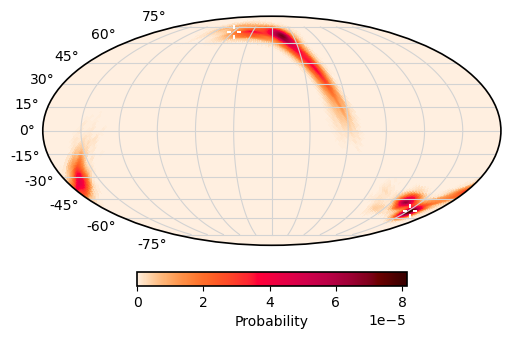

In [5]:
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(111, projection="mollweide")

# Flipping the data in order to use the typical view with RA inverted
cmesh = ax.pcolormesh(ra_grid, dec_grid, np.flip(data_ligo_2d, axis=1), cmap="cylon")

ax.plot(
    -(((hotspot_coords.ra.rad + np.pi) % (2*np.pi)) - np.pi), # Wrapping -180, 180 and inverting
    hotspot_coords.dec.rad, 
    marker=ligo.skymap.plot.reticle(), markersize=10, color="w", markeredgewidth=1.4
)
ax.plot(
    -(((coord_2.ra.rad + np.pi) % (2*np.pi)) - np.pi), # Wrapping -180, 180 and inverting
    coord_2.dec.rad, 
    marker=ligo.skymap.plot.reticle(), markersize=10, color="w", markeredgewidth=1.4
)

plt.grid(color="lightgray")
cbar = plt.colorbar(cmesh, ax=ax, orientation="horizontal", pad=0.1, fraction=0.05, aspect=20, 
                    label="Probability density")
ax.spines["geo"].set_linewidth(1.2); cbar.outline.set_linewidth(1.2)
ax.set_xticklabels([])

if store_plots == True:
    plt.savefig(dir_plots + f"plot_LIGO_mollweide_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

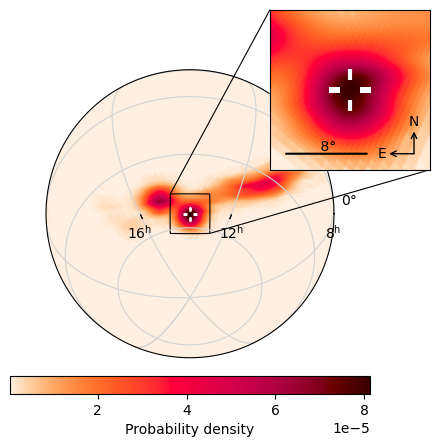

In [6]:
fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.add_subplot(
    [0.05, 0.05, 0.9, 0.9],
    projection="astro globe",
    center=hotspot_coords)
ax_inset = fig.add_subplot(
    [0.7, 0.7, 0.4, 0.4],
    projection = "astro zoom",
    center = hotspot_coords,
    radius = zoom_radius)

for key in ["ra", "dec"]:
    ax_inset.coords[key].set_ticklabel_visible(False); ax_inset.coords[key].set_ticks_visible(False)
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, "upper left", zorder=10)
ax.connect_inset_axes(ax_inset, "lower right", zorder=10)
ax_inset.scalebar((0.1, 0.1), zoom_radius).label()
ax_inset.compass(0.9, 0.1, 0.2)
ax.grid(color="lightgray")


for axe, ms, mw in zip([ax, ax_inset], [10, 30], [2, 3]):
    imshow = axe.imshow_hpx(data_ligo_hp, cmap="cylon")
    
    axe.plot(
        hotspot_coords.ra.deg, hotspot_coords.dec.deg,
        transform=axe.get_transform("world"),
        marker=ligo.skymap.plot.reticle(),
        markersize=ms, color="w",
        markeredgewidth=mw)
cbar = fig.colorbar(
    imshow, ax=ax, orientation="horizontal", pad=0.05, label="Probability density")

if store_plots == True:
    plt.savefig(dir_plots + f"plot_LIGO_astroglobe_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

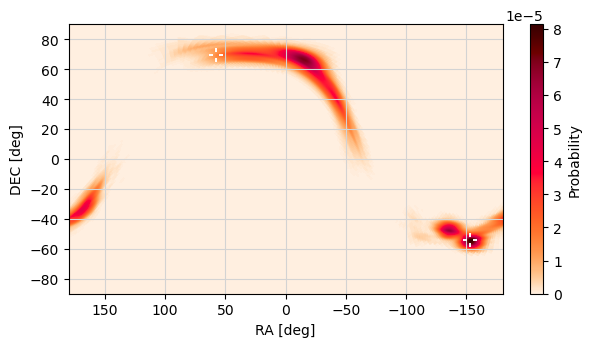

In [7]:
fig, ax = plt.subplots(figsize=(7, 3.5))

# Flipping the data in order to use the typical view with RA inverted
cmesh = ax.imshow(np.flip(data_ligo_2d, axis=1), extent=[180, -180, -90, 90], 
                  origin="lower", aspect="auto", cmap="cylon")

ax.plot(
    (((hotspot_coords.ra.deg + 180) % 360) - 180), # Wrapping -180, 180 and inverting
    hotspot_coords.dec.deg, 
    marker=ligo.skymap.plot.reticle(), markersize=10, color="w", markeredgewidth=1.4
)

ax.plot(
    (((coord_2.ra.deg + 180) % 360) - 180), # Wrapping -180, 180 and inverting
    coord_2.dec.deg, 
    marker=ligo.skymap.plot.reticle(), markersize=10, color="w", markeredgewidth=1.4
)

plt.grid(color="lightgray")
ax.set_xlabel("RA [deg]"); ax.set_ylabel("DEC [deg]")
cbar = plt.colorbar(cmesh, ax=ax, orientation="vertical", label="Probability density")

if store_plots == True:
    plt.savefig(dir_plots + f"plot_LIGO_cartesian_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

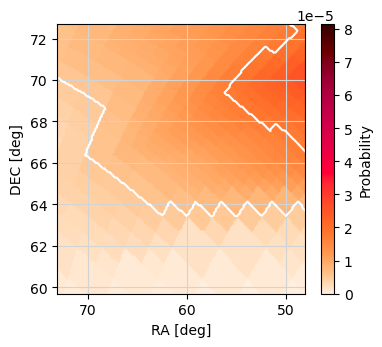

In [8]:
fig, ax = plt.subplots(figsize=(4, 3.5))

# --- skymap --- #
cmesh = ax.imshow(
    np.flip(data_ligo_2d, axis=1), # Flipping data to plot in inverted RA view
    extent=[180, -180, -90, 90], 
    aspect="auto", origin="lower", cmap="cylon",
)

# --- GW contour --- #
ax.contour(
    np.flip(data_ligo_2d, axis=1),
    extent=[180, -180, -90, 90], 
    origin="lower", levels=threshold_maps, linewidths=1.5, colors="w")

# --- hotspot --- #
ax.plot(
    hotspot_coords.ra.wrap_at(180 * u.deg).value, # Wrapping in -180, 180
    hotspot_coords.dec.deg, 
    marker=ligo.skymap.plot.reticle(), markersize=20, color="w", markeredgewidth=1.4
)
ax.plot(
    coord_2.ra.wrap_at(180 * u.deg).value, # Wrapping in -180, 180
    coord_2.dec.deg, 
    marker=ligo.skymap.plot.reticle(), markersize=20, color="w", markeredgewidth=1.4
)

ax.grid(color="lightgray"); ax.set_facecolor("0.1")
ax.set_xlabel("RA [deg]"); ax.set_ylabel("DEC [deg]")
cbar = plt.colorbar(cmesh, ax=ax, orientation="vertical", label="Probability density")

# ax.set_xlim(hotspot_coords.ra.deg+3, hotspot_coords.ra.deg-3)
# ax.set_ylim(hotspot_coords.dec.deg-3, hotspot_coords.dec.deg+3)
ax.set_xlim(coord_2.ra.deg+15, coord_2.ra.deg-10)
ax.set_ylim(coord_2.dec.deg-10, coord_2.dec.deg+3)

if store_plots == True:
    plt.savefig(dir_plots + f"plot_LIGO_cartesian_zoom_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

# EXAMPLES FROM HEALPY

## Different axes

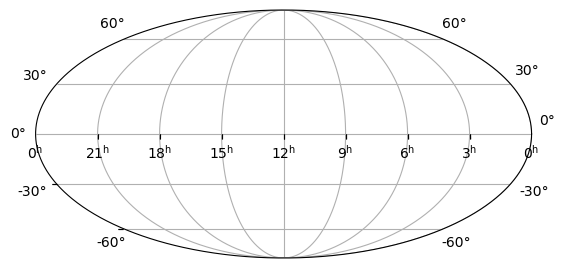

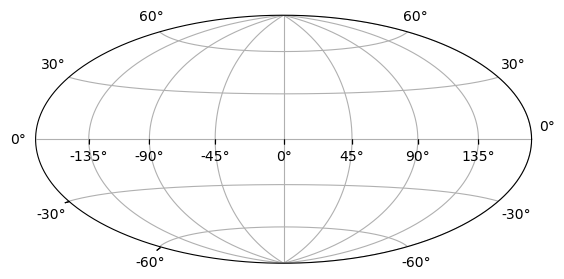

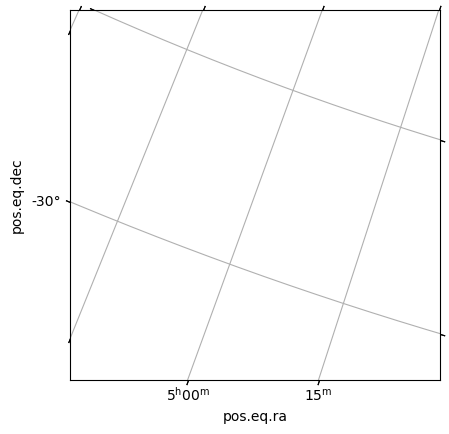

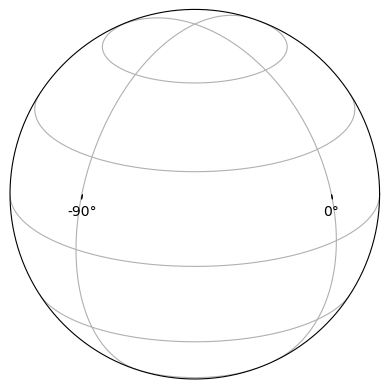

In [9]:
ax = plt.axes(projection='astro hours mollweide')
ax.grid()
plt.show()

ax = plt.axes(projection='geo aitoff')
ax.grid()
plt.show()

ax = plt.axes(projection='astro zoom',
              center='5h -32d', radius='5 deg', rotate='20 deg')
ax.grid()
plt.show()

ax = plt.axes(projection='geo globe', center='-50d +23d')
ax.grid()
plt.show()

## Insets

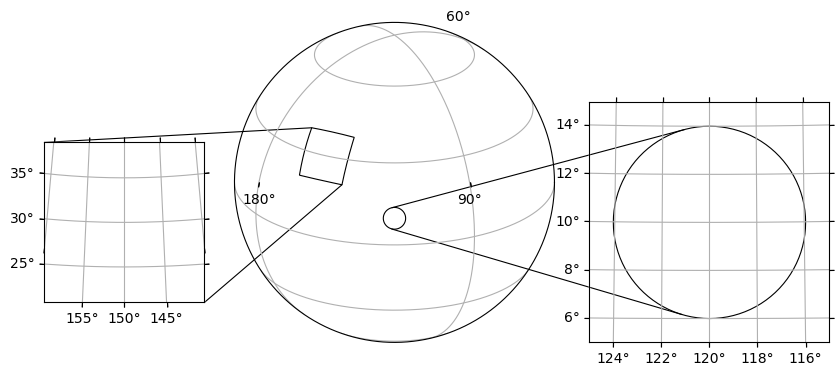

In [10]:
fig = plt.figure(figsize=(9, 4), dpi=100)

ax_globe = plt.axes(
    [0.1, 0.1, 0.8, 0.8],
    projection='astro degrees globe',
    center='120d +23d')

ax_zoom_rect = plt.axes(
    [0.0, 0.2, 0.4, 0.4],
    projection='astro degrees zoom',
    center='150d +30d',
    radius='9 deg')

ax_zoom_circle = plt.axes(
    [0.55, 0.1, 0.6, 0.6],
    projection='astro degrees zoom',
    center='120d +10d',
    radius='5 deg')

ax_globe.mark_inset_axes(ax_zoom_rect)
ax_globe.connect_inset_axes(ax_zoom_rect, 'upper left')
ax_globe.connect_inset_axes(ax_zoom_rect, 'lower right')

ax_globe.mark_inset_circle(ax_zoom_circle, '120d +10d', '4 deg')
ax_globe.connect_inset_circle(ax_zoom_circle, '120d +10d', '4 deg')

ax_globe.grid()
ax_zoom_rect.grid()
ax_zoom_circle.grid()

for ax in [ax_globe, ax_zoom_rect, ax_zoom_circle]:
    ax.set_facecolor('none')
    for key in ['ra', 'dec']:
        ax.coords[key].set_auto_axislabel(False)

## Complete example

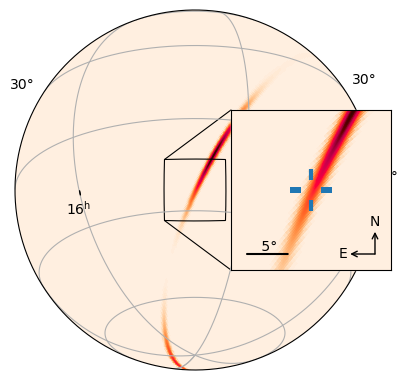

In [11]:
url = './data/bayestar_no_virgo.fits.gz'
center = SkyCoord.from_name('NGC 4993')

fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx(url, cmap='cylon')
ax_inset.imshow_hpx(url, cmap='cylon')
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3)

## Backdrop images

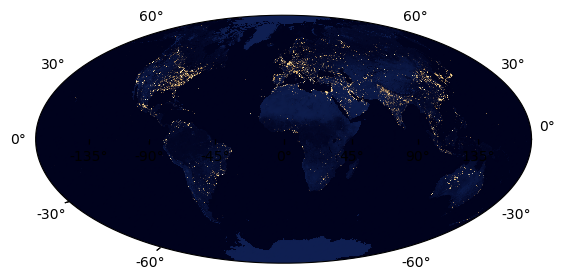

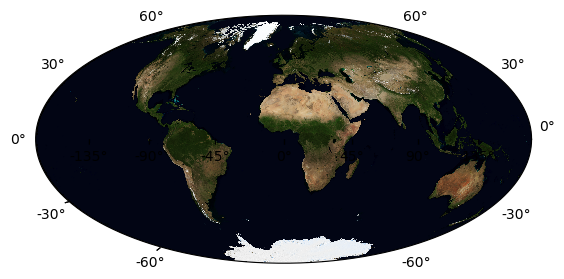

In [12]:
obstime = '2017-08-17 12:41:04'
ax = plt.axes(projection='geo degrees aitoff', obstime=obstime)
ax.imshow(reproject_interp_rgb(blackmarble(obstime), ax.header))
plt.show()

obstime = '2017-08-17 12:41:04'
ax = plt.axes(projection='geo degrees aitoff', obstime=obstime)
ax.imshow(reproject_interp_rgb(bluemarble(obstime), ax.header))
plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


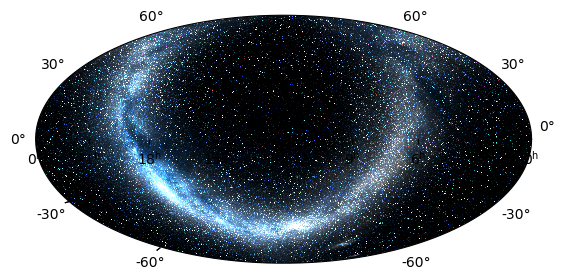

In [13]:
from astropy.visualization import (ImageNormalize,
                                   AsymmetricPercentileInterval)
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from ligo.skymap.plot import mellinger
from reproject import reproject_interp

ax = plt.axes(projection='astro hours aitoff')
backdrop = mellinger()
backdrop_wcs = WCS(backdrop.header).dropaxis(-1)
interval = AsymmetricPercentileInterval(45, 98)
norm = ImageNormalize(backdrop.data, interval)
backdrop_reprojected = np.asarray([
    reproject_interp((layer, backdrop_wcs), ax.header)[0]
    for layer in norm(backdrop.data)])
backdrop_reprojected = np.rollaxis(backdrop_reprojected, 0, 3)
ax.imshow(backdrop_reprojected)